# Loading packages

Note: a new folder was created for this model because the kernel continued to crash. 

In [24]:
import numpy as np
import pandas as pd
from random import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os 
import matplotlib.image as mimg
import tensorflow as tf
import xgboost as xgb


from PIL import Image
from scipy import misc
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, Activation, Dropout, Flatten, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

# Image preprocessing

In [25]:
num_skipped = 0
for folder_name in ("Cats", "Dogs"):
    folder_path = os.path.join('/Users/chiarasaini/Desktop/CatsDogs', folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()
        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)
print("Deleted %d images" % num_skipped)

Deleted 0 images


In [26]:
PATH = '/Users/chiarasaini/Desktop/CatsDogs/'
CATEGORIES = ['Cats', 'Dogs']

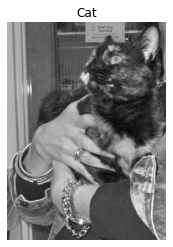

In [27]:
for category in CATEGORIES:
    path = os.path.join(PATH, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        plt.imshow(img_array, cmap="gray")
        plt.title('Cat')
        plt.axis('off')
        plt.show()
        break
    break

In [28]:
print(img_array)

[[174 175 177 ... 134 133 132]
 [175 176 178 ... 135 134 132]
 [177 178 179 ... 137 136 134]
 ...
 [ 56  55  58 ... 168 165 174]
 [ 57  56  58 ... 157 150 153]
 [ 58  56  58 ... 156 143 139]]


In [29]:
print(img_array.shape)

(500, 365)


Text(0.5, 0, 'shape: (180, 180)')

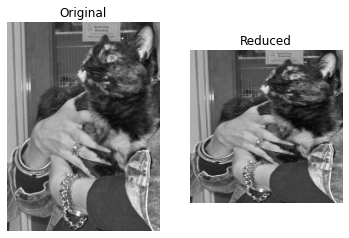

In [30]:
plt.subplot(1,2,1)
plt.imshow(img_array, cmap='gray')
plt.title('Original')
plt.axis('off')
plt.xlabel('shape: {}'.format(img_array.shape))
plt.subplot(1,2,2)

IMG_SIZE = 180
new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap='gray')
plt.title('Reduced')
plt.axis('off')
plt.xlabel('shape: {}'.format(new_array.shape))

In [31]:
training_data = []
class_list =[]

def create_training_data():
    for category in CATEGORIES: 

        path = os.path.join(PATH,category) 
        class_num = CATEGORIES.index(category)  
        for img in os.listdir(path):  
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)) 
                training_data.append([new_array, class_num])  
                class_list.append(class_num)
            except Exception as e:  
                pass
            

create_training_data()

print(len(training_data))

23410


/Users/davidev7/miniforge3/envs/ch_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

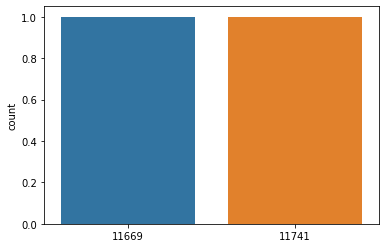

In [32]:
# There seems to be little class imbalance
sns.countplot(pd.Series(class_list).value_counts())

In [33]:
import random

random.shuffle(training_data)

In [34]:
# check if sample worked
for sample in training_data[:10]:
    print(sample[1])

0
1
1
0
1
0
0
1
0
0


In [35]:
X = []
y = []

for features, labels in training_data:
    X.append(features)
    y.append(labels)

    
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y = np.array(y) # labels

# normalising the data
X = X/255

# Model with Cross-Validation

In [36]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (10,7)

In [40]:
def cnn_model(size, num_cnn_layers):
    NUM_FILTERS = 32
    KERNEL = (3, 3)

    
    model_cv = Sequential()
    
    for i in range(1, num_cnn_layers+1):
        if i == 1:
            model_cv.add(Conv2D(NUM_FILTERS*i, KERNEL, input_shape= (180,180,1), activation='relu', padding='same'))
        else:
            model_cv.add(Conv2D(NUM_FILTERS*i, KERNEL, activation='relu', padding='same'))

    model_cv.add(MaxPooling2D(pool_size=(2,2)))
    model_cv.add(Flatten())
    model_cv.add(Dense((512), activation='relu'))
    model_cv.add(Dropout(0.25))
    model_cv.add(Dense(1, activation='sigmoid'))
    
    model_cv.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    
    return model_cv

In [41]:
input_shape_= (180,180,1)

In [42]:
model_cv = cnn_model(input_shape, 2)

In [43]:
model_cv.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 180, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 518400)            0         
                                                                 
 dense (Dense)               (None, 512)               265421312 
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                      

In [44]:
print("Number of layers in the model: ", len(model_cv.layers))
print("Number of parameters in the model: ", model_cv.count_params())

Number of layers in the model:  7
Number of parameters in the model:  265440641


In [47]:
pat = 5 
early_stopping = EarlyStopping(monitor='val_loss', patience=pat, verbose=1)

model_checkpoint = ModelCheckpoint('fas_mnist_1.h5', verbose=1, save_best_only=True)

#define a function to fit the model
def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS=10, BATCH_SIZE=32):
    model = None
    model = cnn_model((180,180,1), 1)
    results = model.fit(t_x, t_y, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping, model_checkpoint], 
              verbose=1, validation_split=0.1)  
    print("Val Score: ", model.evaluate(val_x, val_y))
    return results


In [48]:
n_folds=5
epochs=5
batch_size=32

model_history = [] 

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    t_x, val_x, t_y, val_y = train_test_split(X, y, test_size=0.1, 
                                               random_state = np.random.randint(1,1000, 1)[0])
    model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size))
    print("======="*12, end="\n\n\n")

Training on Fold:  1
Epoch 1/5
593/593 [==============================] - ETA: 0s - loss: 0.8054 - accuracy: 0.6366
Epoch 1: val_loss improved from inf to 0.60902, saving model to fas_mnist_1.h5
593/593 [==============================] - 173s 288ms/step - loss: 0.8054 - accuracy: 0.6366 - val_loss: 0.6090 - val_accuracy: 0.6716
Epoch 2/5
593/593 [==============================] - ETA: 0s - loss: 0.5081 - accuracy: 0.7526
Epoch 2: val_loss improved from 0.60902 to 0.54454, saving model to fas_mnist_1.h5
593/593 [==============================] - 169s 286ms/step - loss: 0.5081 - accuracy: 0.7526 - val_loss: 0.5445 - val_accuracy: 0.7190
Epoch 3/5
593/593 [==============================] - ETA: 0s - loss: 0.3861 - accuracy: 0.8227
Epoch 3: val_loss did not improve from 0.54454
593/593 [==============================] - 168s 283ms/step - loss: 0.3861 - accuracy: 0.8227 - val_loss: 0.6019 - val_accuracy: 0.7186
Epoch 4/5
593/593 [==============================] - ETA: 0s - loss: 0.2629 - ac

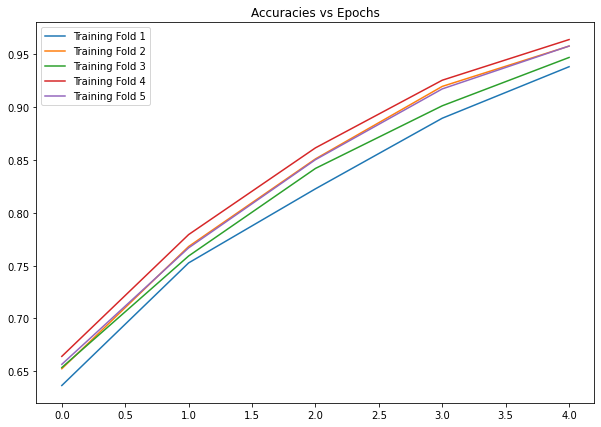

In [49]:
plt.title('Accuracies vs Epochs')
plt.plot(model_history[0].history['accuracy'], label='Training Fold 1')
plt.plot(model_history[1].history['accuracy'], label='Training Fold 2')
plt.plot(model_history[2].history['accuracy'], label='Training Fold 3')
plt.plot(model_history[3].history['accuracy'], label='Training Fold 4')
plt.plot(model_history[4].history['accuracy'], label='Training Fold 5')
plt.legend()
plt.show()

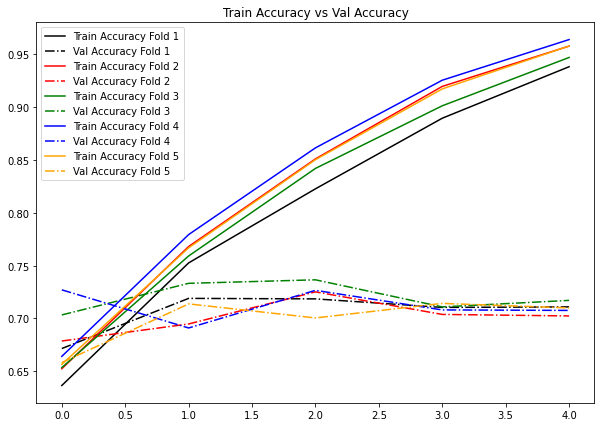

In [50]:
plt.title('Train Accuracy vs Val Accuracy')
plt.plot(model_history[0].history['accuracy'], label='Train Accuracy Fold 1', color='black')
plt.plot(model_history[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")

plt.plot(model_history[1].history['accuracy'], label='Train Accuracy Fold 2', color='red', )
plt.plot(model_history[1].history['val_accuracy'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")

plt.plot(model_history[2].history['accuracy'], label='Train Accuracy Fold 3', color='green', )
plt.plot(model_history[2].history['val_accuracy'], label='Val Accuracy Fold 3', color='green', linestyle = "dashdot")

plt.plot(model_history[3].history['accuracy'], label='Train Accuracy Fold 4', color='blue', )
plt.plot(model_history[3].history['val_accuracy'], label='Val Accuracy Fold 4', color='blue', linestyle = "dashdot")

plt.plot(model_history[4].history['accuracy'], label='Train Accuracy Fold 5', color='orange', )
plt.plot(model_history[4].history['val_accuracy'], label='Val Accuracy Fold 5', color='orange', linestyle = "dashdot")

plt.legend()
plt.show()